**EIE558 Lab 1: DNN-based Speech Enhancement**

*Introduction*

This lab exercise uses Deep Complex U-Net (DCUnet) for speech enhancement. The algorithm and code are based on the paper "Phase-Aware Speech Enhancement with Deep Complex U-Net" by H.S. Choi et al. (2019). The codes have been modified so that the network can use 16kHz wave files for both training and evaluations (It is overkill to sample speech signals at 48kHz because the human speech production system cannot produce sounds beyond 8kHz). The architecture of the DCUnet is shown in the digram below. The numbers above the boxes are the size of the 4-dim tensors:  [no. channels x no. freq bins x no. of frames x 2], where the last entry contains real and imaginary parts of individual frequency components. The blue and green arrows represent down- and up-sampling, respectively. The up and down sampling involve Conv2D followed by batch normalization.

The following procedure will create a folder "Learning/EIE558/DCUnet16" under your Google Drive. You may need to re-run some of the steps if the connection to Colab has expired. For the steps that download data and programs, you do not need to re-run them because the data and programs are stored on your Google Drive. 

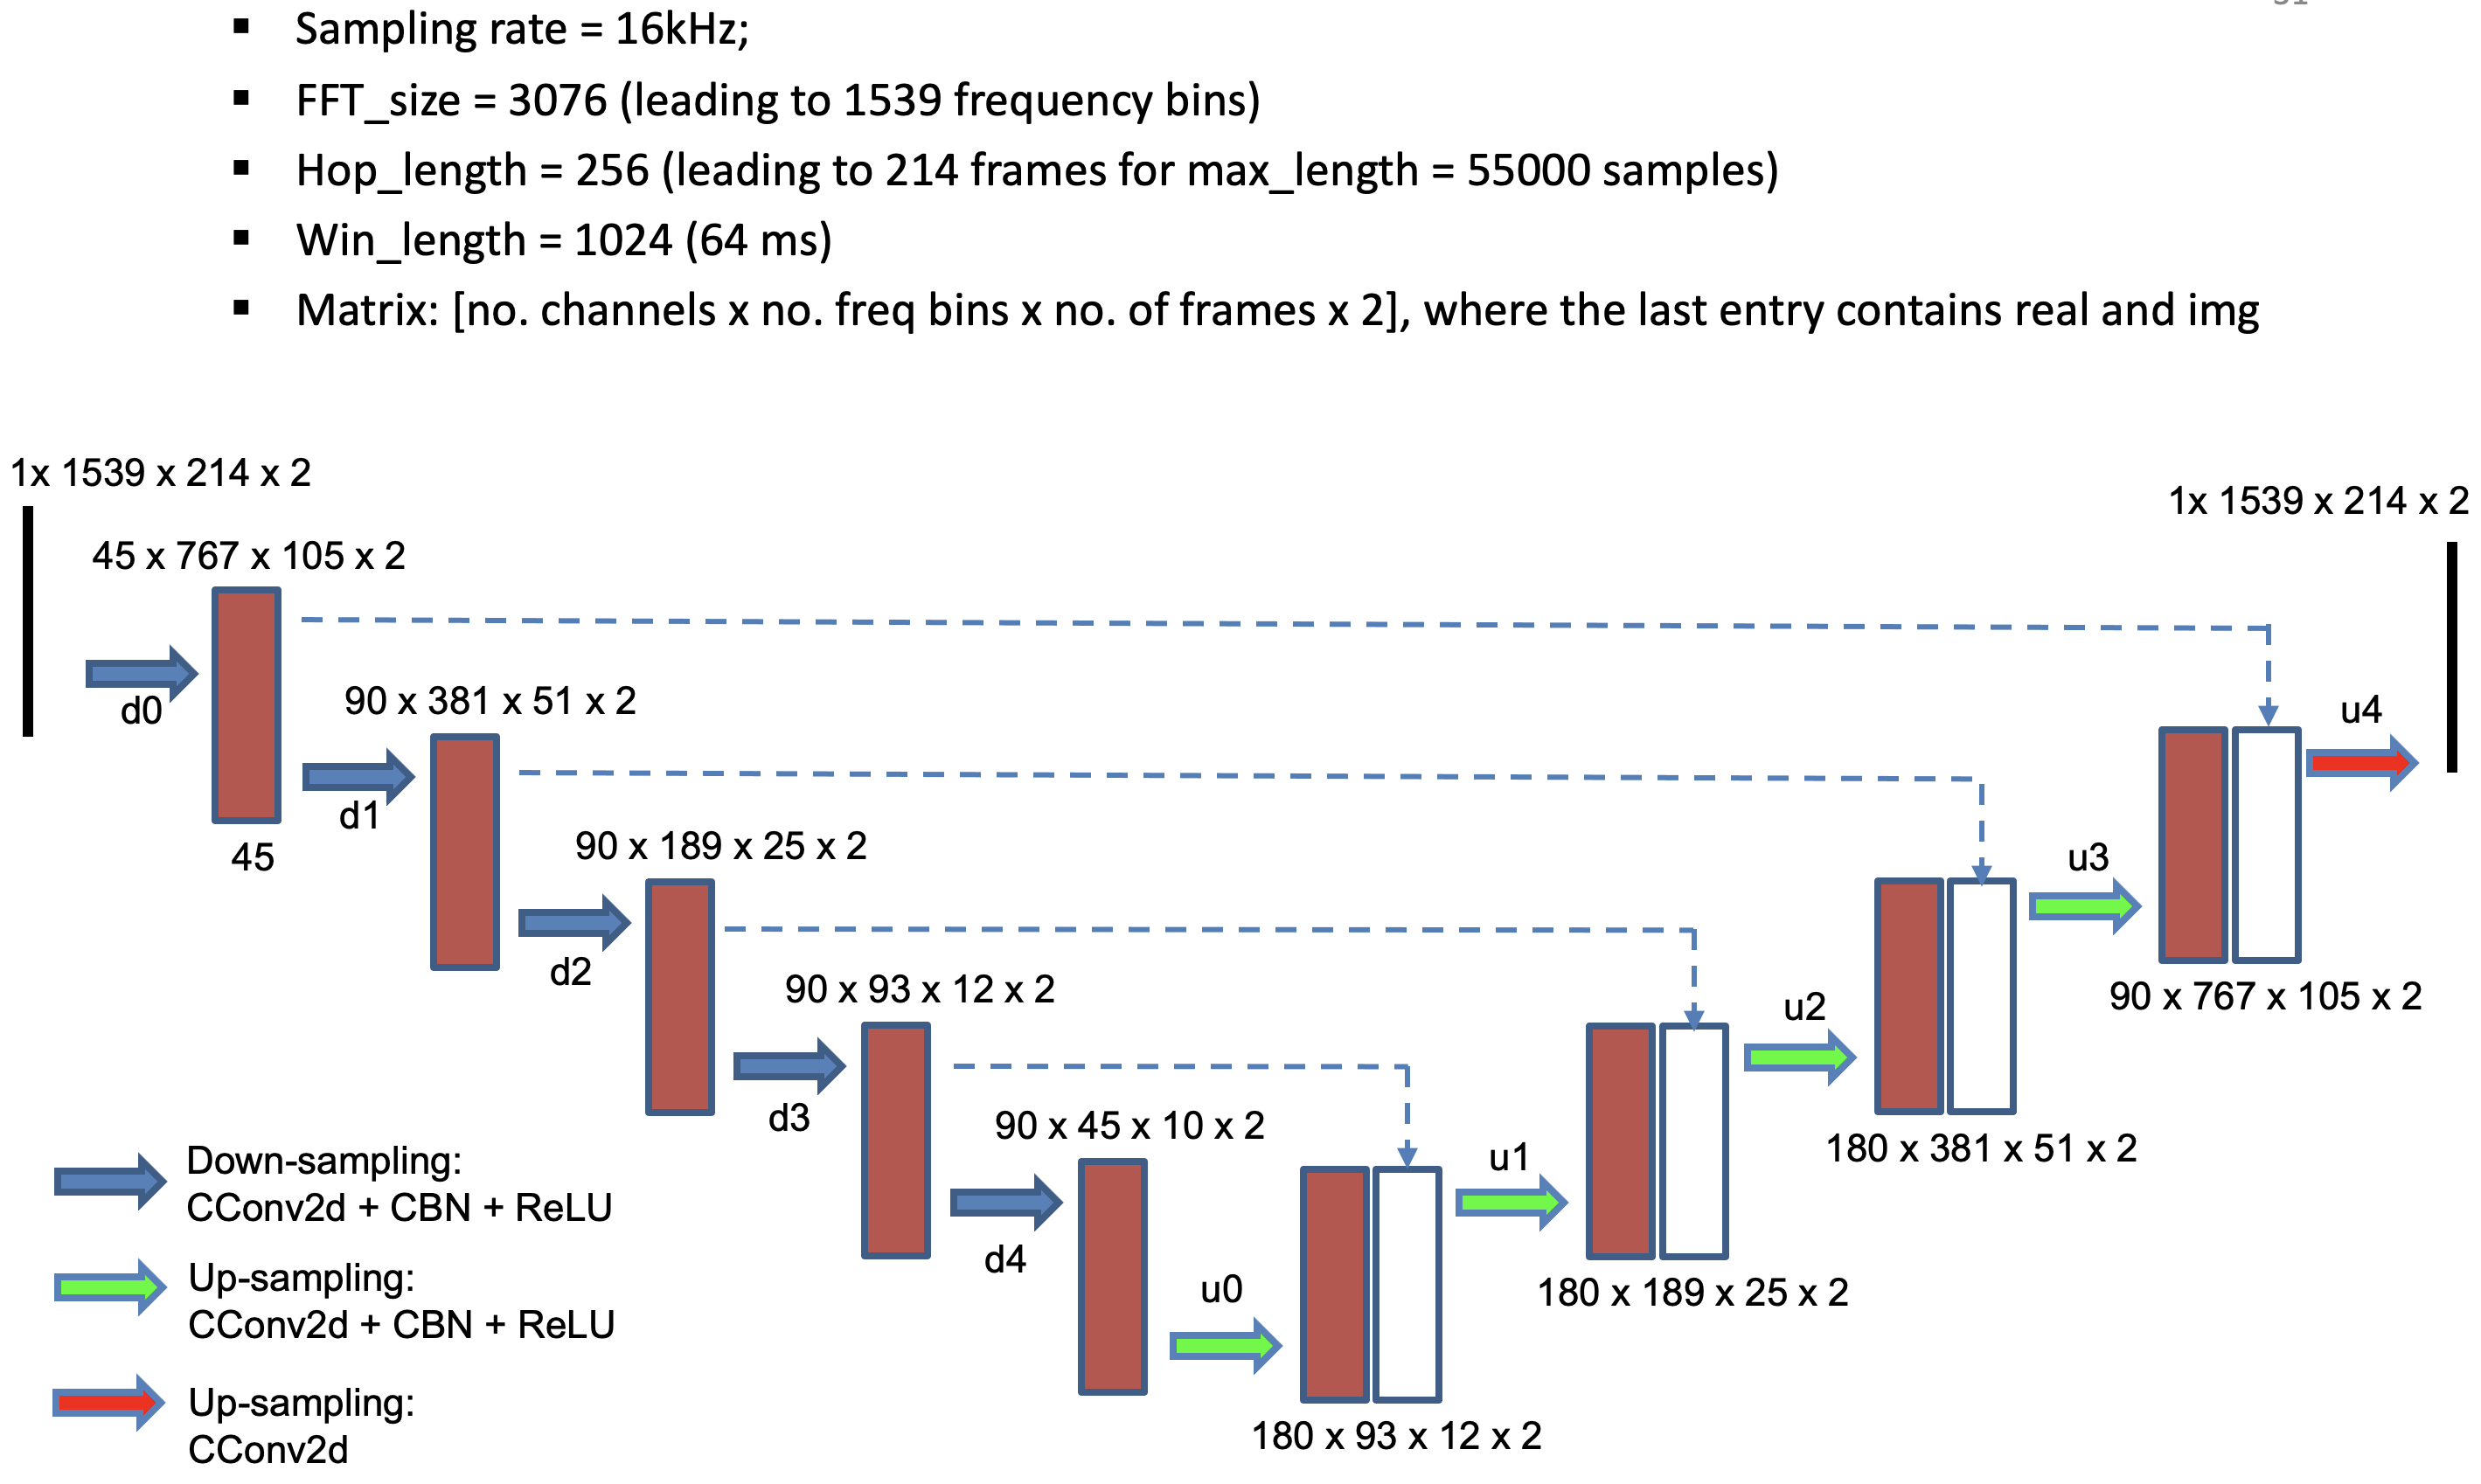

*Step 1: Install the version of Pytorch, Torchaudio and PESQ packages that work with the DCUnet code. Note that you will need to repeat this step if your Colab session has expired.*

In [ ]:
# Find out the current installed version of torch and torchaudio
# If torch is not 1.5.0 and torchaudio is not 0.5, we need to reinstall the correct versions
import torch, torchaudio
print(torch.__version__)
print(torchaudio.__version__)

1.10.0+cu111
0.10.0+cu111


In [2]:
# Installing torchaudio 0.5 will automatically install torch 1.5.0
!pip3 install torchaudio==0.5

     |████████████████████████████████| 3.2 MB 5.4 MB/s 
     |████████████████████████████████| 752.0 MB 10 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.5.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0 which is incompatible.


In [9]:
# Making sure the versions are correct. If you do not see 1.5.1 and 0.5 for torch and
# torchaudio, respectively, you need to restart your run-time
import torch, torchaudio
print(torch.__version__)
print(torchaudio.__version__)

1.5.0
0.5.0


In [3]:
!pip install pesq

  Created wheel for pesq: filename=pesq-0.0.3-cp37-cp37m-linux_x86_64.whl size=210462 sha256=aea15240eda56e6c5f9be9d1155760fb61f201a0874aadb50f70416e17c4512e
  Stored in directory: /root/.cache/pip/wheels/4f/67/5b/aa7cf31fe0c7199e35c604bb7bc91c629a13726bf221fedba0
Successfully built pesq


*Step 2: Mount Google Drive*

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


*Step 3: Create working directory and download DCUnet programs and model files*

In [2]:
!mkdir -p /content/drive/MyDrive/Learning/EIE558
%cd /content/drive/MyDrive/Learning/EIE558

/content/drive/MyDrive/Learning/EIE558


In [ ]:
!if [ ! -f DCUnet16.tgz ]; then wget http://bioinfo.eie.polyu.edu.hk/download/EIE558/DCUnet/DCUnet16.tgz; fi
!tar zxf DCUnet16.tgz
!rm -f *.tgz*

--2022-03-01 05:11:22--  http://bioinfo.eie.polyu.edu.hk/download/EIE558/DCUnet/DCUnet16.tgz
Resolving bioinfo.eie.polyu.edu.hk (bioinfo.eie.polyu.edu.hk)... 158.132.151.227
Connecting to bioinfo.eie.polyu.edu.hk (bioinfo.eie.polyu.edu.hk)|158.132.151.227|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18987414 (18M)
Saving to: ‘DCUnet16.tgz’

DCUnet16.tgz        100%[===================>]  18.11M   254KB/s    in 83s     

2022-03-01 05:12:46 (222 KB/s) - ‘DCUnet16.tgz’ saved [18987414/18987414]



In [3]:
%cd DCUnet16
!ls

/content/drive/MyDrive/Learning/EIE558/DCUnet16
audio	    dc-unet_test.py  __pycache__       SpeechDataset.py
data	    __MACOSX	     readme	       stft-istft-example.py
dc-net.py   model.py	     requirements.txt
dc-unet.py  models	     scripts


*Step 4: Create data/ directory and download training and test data. If the server "bioinfo.eie.polyu.edu.hk" too busy, you may click this [link](https://polyuit-my.sharepoint.com/:u:/g/personal/enmwmak_polyu_edu_hk/EV8xnLDby1VFk9WuMwbjgLEB8k1BFRrCgRg--UJGfb_vBg?e=RQTjih) to download the same zip file in OneDrive. It will take about 15 minutes to download. Then, upload the zip file to your Google drive and decompress it.*

In [ ]:
%%sh
dir="data" 
if [ ! -d $dir ]; then
  echo "Directory $dir does not exist. Downloading ${dir}.zip"
  wget http://bioinfo.eie.polyu.edu.hk/download/EIE558/DCUnet/${dir}.zip;
  unzip -o ${dir}.zip;
  rm -f ${dir}.zip*;
else
  echo "Directory $dir already exist"
fi

Process is interrupted.


In [ ]:
!du -s -h ./*

/content/drive/MyDrive/Learning/EIE558/DCUnet16
1.3M	./audio
1.7G	./data
1.9G	./data.zip
12K	./dc-net.py
12K	./dc-unet.py
3.5K	./dc-unet_test.py
3.4M	./__MACOSX
12K	./model.py
19M	./models
25K	./__pycache__
512	./readme
512	./requirements.txt
5.0K	./scripts
2.5K	./SpeechDataset.py
1.5K	./stft-istft-example.py


*Step 5: Train a DCUnet and save it to the directory model/. It will take several hours. Skip this step if you want to use the pre-trained model in the folder DCUnet16/models/.*

In [ ]:
%cd /content/drive/MyDrive/Learning/EIE558/DCUnet16
!python3 dc-unet.py train

*Step 6: Test the DCUnet. Modify the file "dc-unet.py" on your Google drive folder "Learning/EIE558/DCUnet16/" so that it print out your name in this step. This is to demonstrate that the work is done by you.*

In [12]:
!python3 dc-unet.py test

8712
7118
Test mode
PESQ = 1.6832859516143799
<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>


*Step 7: Display and play the clean, noisy, and denoised wavefiles. Add your name to the display. Capture the screens (with your name) and put them into your report.*

Clean speech (M.W. Mak)


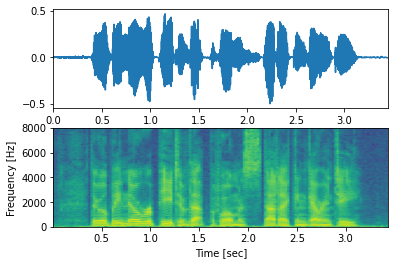

In [13]:
# Clean speech
from IPython.display import Audio
import soundfile as sf
clean_speech, srate = sf.read('audio/eval/clean/rec1.wav')
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(nrows=2)
time = np.arange(clean_speech.shape[0])/srate
ax1.plot(time, clean_speech)
ax1.set_xlim([0, time[-1]])
ax2.specgram(clean_speech, NFFT=512, Fs=srate, noverlap=128)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
print('Clean speech (M.W. Mak)')
Audio(clean_speech, rate=srate)

Noisy speech (M.W. Mak)


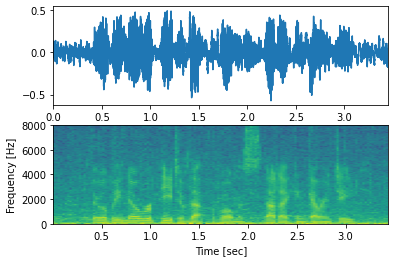

In [14]:
# Noisy speech
from IPython.display import Audio
import soundfile as sf
noisy_speech, srate = sf.read('audio/eval/noisy/rec1.wav')
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(nrows=2)
time = np.arange(noisy_speech.shape[0])/srate
ax1.plot(time, noisy_speech)
ax1.set_xlim([0, time[-1]])
ax2.specgram(noisy_speech, NFFT=512, Fs=srate, noverlap=128)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
print('Noisy speech (M.W. Mak)')
Audio(noisy_speech, rate=srate) 

Denoised speech (M.W. Mak)


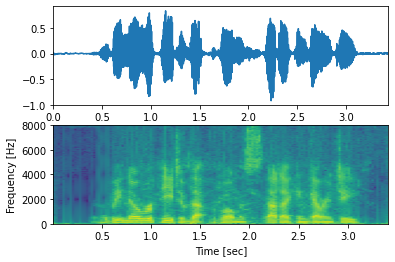

In [15]:
# Denoised speech
from IPython.display import Audio
import soundfile as sf
denoised_speech, srate = sf.read('audio/dc-unet-denoised.wav')
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(nrows=2)
time = np.arange(denoised_speech.shape[0])/srate
ax1.plot(time, denoised_speech)
ax1.set_xlim([0, time[-1]])
ax2.specgram(denoised_speech, NFFT=512, Fs=srate, noverlap=128)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
print('Denoised speech (M.W. Mak)')
Audio(denoised_speech, rate=srate) 

*Step 8: Repeat Steps 5-7 using the program dc-net.py. This program implements a network that does not have any skipped connections between the encoder and the decoder. That's why the letter "u" in the filename has been removed.*

In [5]:
%cd /content/drive/MyDrive/Learning/EIE558/DCUnet16
!python3 dc-unet_test.py --noised_wav data/my_test_wavfiles/street/0dB/sp06_street_sn0.wav --denoised_wav audio/dc-unet-denoised.wav

/content/drive/MyDrive/Learning/EIE558/DCUnet16
Test mode
<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>
